---
title: HMM Brown Corpus
subtitle: Testing my first implementation of an HMM, handbuilt. This uses the Brown Corpus dataset from Kaggle.
author: Michael Cusack-Nelkin
date: 'May 7th, 2025'
format:
    html:
        code-fold: true
---

In [1]:
#activate venv
#!python3 -m venv .venv
!source .venv/bin/activate

In [2]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import random

In [3]:
class HMM_Brown:
    def __init__(self,N,M,seq, loud = False):
        #init observation sequence and dimensions
        self.seq = seq
        self.N = N
        self.M = M
        self.T = len(seq)
        self.loud = loud

        #Init transition, emission, and intitializaiton matrices
        self.A = np.random.dirichlet(np.ones(N), size=N)
        self.B = np.random.dirichlet(np.ones(M), size=N)
        self.pi = np.random.dirichlet(np.ones(N), size=1)

        #iteration variables
        self.old_logprob = -np.inf
        self.alpha = np.zeros([self.T,self.N])
        self.scale = np.zeros([self.T,1])
        self.beta = np.zeros([self.T,self.N])
        self.gamma = np.zeros([self.T,self.N])
        self.digamma = np.zeros([self.T,self.N,self.N])

        #for plotting
        self.logprobs = []

    def alpha_pass(self):
        """Alpha pass is a standalone forward pass function. It takes in A,B,pi,seq and outputs the alphas and scalar 
        by recursively summing the probabilities of the partial observation sequences up to times t, until the final observation.
        The values of alpha are scaled along the way to prevent underflow."""
        
        #computes alpha[0] (the first row of alpha) and c0 (initial scaler)
        c0 = 0
        for i in range(self.N):
            self.alpha[0][i] = self.pi[0][i] * self.B[i][self.seq[0]]
            c0 += self.alpha[0][i]
        self.scale[0][0] = 1/c0
        
        #scale alpha[0]
        for i in range(self.N):
            self.alpha[0][i] = self.scale[0][0] * self.alpha[0][i]

        #computes and scales alpha[t][i], as entries in an alpha matrix
        for t in range(1,self.T):
            c_t = 0
            for i in range(self.N):
                self.alpha[t][i] = 0 
                for j in range(self.N):
                    self.alpha[t][i] += self.alpha[t-1][j] * self.A[j,i]
                self.alpha[t][i] = self.alpha[t][i] * self.B[i][self.seq[t]]
                c_t += self.alpha[t][i]
            self.scale[t][0] = 1/c_t
            #scale alpha[t][i]
            for i in range(self.N):
                self.alpha[t][i] = self.scale[t][0] * self.alpha[t][i]

    def beta_pass(self):
        """Beta pass is a standalone backward pass function. It takes in A, B, observation sequence, and scalar and outputs the betas
        by recursively summing the probabilities of the partial observation sequences backward from the final observation to a time t, until the initial observation.
        The values of beta are scaled (by c, determined by the alpha pass) along the way to prevent underflow."""

        #let beta[T-1][i] = 1, scaled by c[T-1]
        for i in range(self.N):
            self.beta[self.T-1][i] = self.scale[self.T-1][0]
        
        #computes and scales beta[t][i] as entries in the beta matrix. Goes from bottom to top.
        for t in list(range(-1*self.T,-1))[::-1]: #this indexes beta bottom-to-top, skipping the bottom row (T-1)
            for i in range(self.N):
                self.beta[t][i] = 0
                for j in range(self.N):
                    self.beta[t][i] += self.A[i,j] * self.B[j][self.seq[t+1]] * self.beta[t+1][j]
                #scale beta[t][i]
                self.beta[t][i] = self.scale[t][0] * self.beta[t][i]

    def gamma_pass(self):
        """Gammas calculates the gamma and digamma. It takes in A, B, observation sequence, and scalars and outputs the gamma[i]'s (probability of being in state q_i at time t)
        and digamma[i][j]'s (probability of being in state q_i at time t and state q_j at time t+1).
        The values of alpha and beta are scaled (by c, determined by the alpha pass) along the way to prevent underflow, so the gamma and digamma are not scaled."""

        for t in range(self.T-1):
            for i in range (self.N):
                self.gamma[t][i] = 0
                for j in range(self.N):
                    self.digamma[t][i][j] = self.alpha[t][i] * self.A[i][j] * self.B[j][self.seq[t+1]] * self.beta[t+1][j]
                    self.gamma[t][i] += self.digamma[t][i][j]
            
        #special case for gamma[i][T-1]
        for i in range(self.N):
            self.gamma[self.T-1][i] = self.alpha[self.T-1][i]
    
    def get_logprob(self):
        logprob = 0
        for t in range(self.T):
            logprob += math.log(self.scale[t][0])
        return -logprob
    
    def restimate(self):
        
        #restimate pi
        for i in range(self.N):
            self.pi[0][i] = self.gamma[0][i]

        #restimate A
        for i in range(self.N):
            denom = 0
            for t in range(self.T-1):
                denom += self.gamma[t][i]
            for j in range(self.N):
                numer = 0
                for t in range(self.T-1):
                    numer += self.digamma[t][i][j]
                self.A[i][j] = numer / denom
        
        #restimate B
        for i in range(self.N):
            denom = 0
            for t in range(self.T):
                denom += self.gamma[t][i]
            for j in range(self.M):
                numer = 0
                for t in range(self.T):
                    if self.seq[t] == j:
                        numer += self.gamma[t][i]
                self.B[i][j] = numer / denom

    def train(self, max_iters, min_climb):
        for i in range(max_iters+1):
            if i == 0:
                self.alpha_pass()
                self.beta_pass()
                self.gamma_pass()
                self.restimate()
            elif (i < max_iters+1) and (self.get_logprob() - self.old_logprob) > min_climb:
                self.logprobs.append(self.get_logprob())
                self.old_logprob = self.get_logprob()

                self.alpha_pass()
                self.beta_pass()
                self.gamma_pass()
                self.restimate()

                if self.loud == True:
                    print(self.get_logprob())
            else:
                print(f"Train loop complete on iteration {i}. Log Probability: {self.get_logprob()}")
                break

In [4]:
df = pd.read_csv("data/brown_corpus/brown.csv")
data = df.copy()
data

,filename,para_id,sent_id,raw_text,tokenized_text,tokenized_pos,label
0,cd05,0,0,"Furthermore/rb ,/, as/cs an/at encouragement/n...","Furthermore , as an encouragement to revisioni...","rb , cs at nn in nn nn , pps rb bez jj to vb c...",religion
1,cd05,0,1,The/at Unitarian/jj clergy/nns were/bed an/at ...,The Unitarian clergy were an exclusive club of...,at jj nns bed at jj nn in vbn nns -- cs at nn ...,religion
2,cd05,0,2,"Ezra/np Stiles/np Gannett/np ,/, an/at honorab...","Ezra Stiles Gannett , an honorable representat...","np np np , at jj nn in at nn , vbd ppl rb in a...",religion
3,cd05,0,3,"Even/rb so/rb ,/, Gannett/np judiciously/rb ar...","Even so , Gannett judiciously argued , the Ass...","rb rb , np rb vbd , at nn-tl md rb vb cs np ``...",religion
4,cd05,0,4,We/ppss today/nr are/ber not/* entitled/vbn to...,We today are not entitled to excoriate honest ...,ppss nr ber * vbn to vb jj nns wps vbd np to b...,religion
...,...,...,...,...,...,...,...
57335,cj14,6,3,"For/in the/at most/ap part/nn ,/, this/dt disc...","For the most part , this discussion will be co...","in at ap nn , dt nn md be vbn in nns vbn in at...",learned
57336,cj14,6,4,A/np-hl ./.-hl,A .,np-hl .-hl,learned
57337,cj14,6,5,Standard/jj-hl preparations/nns-hl and/cc-hl u...,Standard preparations and units of thyroid-sti...,jj-hl nns-hl cc-hl nns-hl in-hl jj-hl nn-hl,learned
57338,cj14,6,6,The/at international/jj unit/nn (/( u./nn )/) ...,"The international unit ( u. ) , adopted to mak...","at jj nn ( nn ) , vbn to vb jj at nn in nns in...",learned


In [5]:
import re
data = pd.DataFrame(columns=['clean_text'])
data['clean_text'] = df['tokenized_text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

#drop empty rows
data.drop(data[data['clean_text'] == ''].index, inplace=True)
data.reset_index(inplace=True)
data['clean_text'] = data['clean_text'].apply(lambda x: x.lower() if type(x) == str else x)

#creating numerical encoding of the text in terms of position in the alphabet plus ' ': 27
alphabet = {chr(i + 97): str(i) for i in range(26)}
alphabet[' '] = '26'


#slicing to put into the model
sequence = []
for i in range(len(data['clean_text'])):
    if len(sequence) > 50000:
        break
    else:
        temp = list(data['clean_text'][i])
        for t in range(len(temp)):
            temp[t] = ''.join(alphabet.get(char, char) for char in temp[t]) #appends the unicode number associated wiht that letter
            sequence.append(int(temp[t]))

In [6]:
hmm = HMM_Brown(N=2, M=27, seq=sequence, loud=False)
hmm.train(max_iters=1000,min_climb=0.01)

Train loop complete on iteration 100. Log Probability: -136559.9667009361


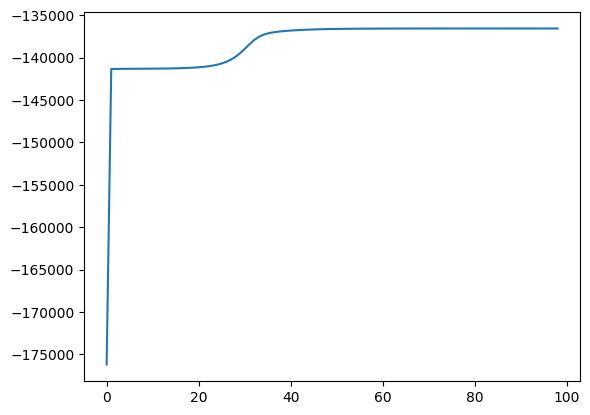

In [7]:
plt.plot(hmm.logprobs)

Below is the emission matrix, showing that each letter has been statistically classified into one class or another. The 27th item is white space, which is not classified as either group.

In [8]:
df_b = pd.DataFrame(hmm.B, columns=alphabet)
df_b

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,
0,1.365548e-01,1.036895e-23,0.001270,0.003173,2.201395e-01,2.872275e-20,0.010020,0.000003,1.355602e-01,1.429980e-46,...,1.260849e-29,0.000006,0.040413,4.817037e-02,3.386122e-52,4.292435e-14,3.546213e-38,0.021461,2.277117e-24,0.246404
1,1.287788e-11,2.304597e-02,0.053995,0.049646,2.540405e-17,3.557257e-02,0.016626,0.083112,1.594934e-17,1.263811e-03,...,9.170066e-02,0.107493,0.111231,4.663468e-10,1.639238e-02,2.445846e-02,4.125972e-03,0.006567,8.921021e-04,0.129823


The transition matrix A is below. The HMM successfully identified two sets of letters, one consonants and one vowels.

In [9]:
df_a = pd.DataFrame(hmm.A)
df_a

,0,1
0,0.180771,0.819229
1,0.704248,0.295752


## Take-Away
This is an experimental write up that is by no means optimal. It is only semi-successful in identifying the vowels and consonants and is heavily dependent on the intital conditions for A and B matrices (drichlet). Nevertheless, I learned a lot and enjoyed the time spent.